# HAR CNN training 

In [377]:
# Imports
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline

In [378]:
%run utils/utilities.py

In [379]:
class_label_vn = [u"Cổ tay",u"Cổ chân",u"Bả vai",u"Xoay người",u"Xoay đầu gối",u"Đi bộ",u"Chạy",u"Đạp xe",u"Đánh răng",u"Rửa tay",u"Lau bàn",u"Nạo",u"Thái",u"Trộn",u"Lên cầu thang",u"Xuống cầu thang"]

## Prepare data

In [380]:
rootDatasetDir = "./datasets/PTIT/normalized"
X_train, labels_train, list_ch_train = read_data(data_path="./datasets/PTIT/normalized", split="train") # train
X_test, labels_test, list_ch_test = read_data(data_path=rootDatasetDir, split="test") # test
assert list_ch_train == list_ch_test, "Mistmatch in channels!"

x_sensor_acc
x_watch_acc
x_watch_gyr
y_sensor_acc
y_watch_acc
y_watch_gyr
z_sensor_acc
z_watch_acc
z_watch_gyr
x_sensor_acc
x_watch_acc
x_watch_gyr
y_sensor_acc
y_watch_acc
y_watch_gyr
z_sensor_acc
z_watch_acc
z_watch_gyr


In [381]:
# Normalize?
X_train, X_test = standardize(X_train, X_test)

Train/Validation Split

In [382]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train, 
                                                stratify = labels_train, random_state = 123)

One-hot encoding:

In [383]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

In [384]:
# Imports
import tensorflow as tf

### Hyperparameters

In [385]:
batch_size = 600       # Batch size
seq_len = WINDOWN_SIZE          # Number of steps or window size
learning_rate = 0.0001
epochs = 2000

n_classes = NUM_CLASS
n_channels = NUM_CHANNEL
print "n_channels %d" % n_channels

n_channels 9


### Construct the graph
Placeholders

In [386]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Build Convolutional Layers

In [387]:
with graph.as_default():
    # (batch, 128, 9) --> (batch, 64, 18)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=18, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
    
    # (batch, 64, 18) --> (batch, 32, 36)
    conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=36, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
    
    # (batch, 32, 36) --> (batch, 16, 72)
    conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=72, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
    
    # (batch, 16, 72) --> (batch, 8, 144)
    conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=144, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')

Now, flatten and pass to the classifier

In [388]:
with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(max_pool_4, (-1, 8*144))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes)
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Train the network

In [389]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

In [390]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints-cnn/har.ckpt")

('Epoch: 0/2000', 'Iteration: 5', 'Train loss: 2.858363', 'Train acc: 0.071667')
('Epoch: 1/2000', 'Iteration: 10', 'Train loss: 2.820016', 'Train acc: 0.068333')
('Epoch: 1/2000', 'Iteration: 10', 'Validation loss: 2.760466', 'Validation acc: 0.071667')
('Epoch: 2/2000', 'Iteration: 15', 'Train loss: 2.767467', 'Train acc: 0.076667')
('Epoch: 3/2000', 'Iteration: 20', 'Train loss: 2.712113', 'Train acc: 0.098333')
('Epoch: 3/2000', 'Iteration: 20', 'Validation loss: 2.689046', 'Validation acc: 0.098333')
('Epoch: 4/2000', 'Iteration: 25', 'Train loss: 2.713872', 'Train acc: 0.100000')
('Epoch: 5/2000', 'Iteration: 30', 'Train loss: 2.670680', 'Train acc: 0.101667')
('Epoch: 5/2000', 'Iteration: 30', 'Validation loss: 2.642451', 'Validation acc: 0.095000')
('Epoch: 6/2000', 'Iteration: 35', 'Train loss: 2.668613', 'Train acc: 0.106667')
('Epoch: 7/2000', 'Iteration: 40', 'Train loss: 2.640273', 'Train acc: 0.111667')
('Epoch: 7/2000', 'Iteration: 40', 'Validation loss: 2.610223', 'Vali

('Epoch: 64/2000', 'Iteration: 325', 'Train loss: 1.407504', 'Train acc: 0.553333')
('Epoch: 65/2000', 'Iteration: 330', 'Train loss: 1.373470', 'Train acc: 0.541667')
('Epoch: 65/2000', 'Iteration: 330', 'Validation loss: 1.328496', 'Validation acc: 0.600000')
('Epoch: 66/2000', 'Iteration: 335', 'Train loss: 1.323758', 'Train acc: 0.566667')
('Epoch: 67/2000', 'Iteration: 340', 'Train loss: 1.347815', 'Train acc: 0.555000')
('Epoch: 67/2000', 'Iteration: 340', 'Validation loss: 1.293897', 'Validation acc: 0.605000')
('Epoch: 68/2000', 'Iteration: 345', 'Train loss: 1.294908', 'Train acc: 0.571667')
('Epoch: 69/2000', 'Iteration: 350', 'Train loss: 1.302216', 'Train acc: 0.568333')
('Epoch: 69/2000', 'Iteration: 350', 'Validation loss: 1.260232', 'Validation acc: 0.620000')
('Epoch: 70/2000', 'Iteration: 355', 'Train loss: 1.283090', 'Train acc: 0.571667')
('Epoch: 71/2000', 'Iteration: 360', 'Train loss: 1.260313', 'Train acc: 0.583333')
('Epoch: 71/2000', 'Iteration: 360', 'Validati

('Epoch: 127/2000', 'Iteration: 640', 'Train loss: 0.686708', 'Train acc: 0.771667')
('Epoch: 127/2000', 'Iteration: 640', 'Validation loss: 0.712298', 'Validation acc: 0.786667')
('Epoch: 128/2000', 'Iteration: 645', 'Train loss: 0.692885', 'Train acc: 0.795000')
('Epoch: 129/2000', 'Iteration: 650', 'Train loss: 0.686818', 'Train acc: 0.793333')
('Epoch: 129/2000', 'Iteration: 650', 'Validation loss: 0.703948', 'Validation acc: 0.793333')
('Epoch: 130/2000', 'Iteration: 655', 'Train loss: 0.658683', 'Train acc: 0.803333')
('Epoch: 131/2000', 'Iteration: 660', 'Train loss: 0.683652', 'Train acc: 0.793333')
('Epoch: 131/2000', 'Iteration: 660', 'Validation loss: 0.694215', 'Validation acc: 0.795000')
('Epoch: 132/2000', 'Iteration: 665', 'Train loss: 0.649913', 'Train acc: 0.801667')
('Epoch: 133/2000', 'Iteration: 670', 'Train loss: 0.650563', 'Train acc: 0.806667')
('Epoch: 133/2000', 'Iteration: 670', 'Validation loss: 0.686871', 'Validation acc: 0.795000')
('Epoch: 134/2000', 'Iter

('Epoch: 189/2000', 'Iteration: 950', 'Train loss: 0.452441', 'Train acc: 0.870000')
('Epoch: 189/2000', 'Iteration: 950', 'Validation loss: 0.540290', 'Validation acc: 0.835000')
('Epoch: 190/2000', 'Iteration: 955', 'Train loss: 0.451448', 'Train acc: 0.858333')
('Epoch: 191/2000', 'Iteration: 960', 'Train loss: 0.439700', 'Train acc: 0.881667')
('Epoch: 191/2000', 'Iteration: 960', 'Validation loss: 0.535441', 'Validation acc: 0.831667')
('Epoch: 192/2000', 'Iteration: 965', 'Train loss: 0.417836', 'Train acc: 0.886667')
('Epoch: 193/2000', 'Iteration: 970', 'Train loss: 0.426814', 'Train acc: 0.878333')
('Epoch: 193/2000', 'Iteration: 970', 'Validation loss: 0.531974', 'Validation acc: 0.836667')
('Epoch: 194/2000', 'Iteration: 975', 'Train loss: 0.444752', 'Train acc: 0.866667')
('Epoch: 195/2000', 'Iteration: 980', 'Train loss: 0.430450', 'Train acc: 0.863333')
('Epoch: 195/2000', 'Iteration: 980', 'Validation loss: 0.531019', 'Validation acc: 0.831667')
('Epoch: 196/2000', 'Iter

('Epoch: 250/2000', 'Iteration: 1255', 'Train loss: 0.327007', 'Train acc: 0.908333')
('Epoch: 251/2000', 'Iteration: 1260', 'Train loss: 0.343761', 'Train acc: 0.900000')
('Epoch: 251/2000', 'Iteration: 1260', 'Validation loss: 0.463211', 'Validation acc: 0.856667')
('Epoch: 252/2000', 'Iteration: 1265', 'Train loss: 0.318062', 'Train acc: 0.913333')
('Epoch: 253/2000', 'Iteration: 1270', 'Train loss: 0.315262', 'Train acc: 0.906667')
('Epoch: 253/2000', 'Iteration: 1270', 'Validation loss: 0.460071', 'Validation acc: 0.860000')
('Epoch: 254/2000', 'Iteration: 1275', 'Train loss: 0.308481', 'Train acc: 0.910000')
('Epoch: 255/2000', 'Iteration: 1280', 'Train loss: 0.338272', 'Train acc: 0.896667')
('Epoch: 255/2000', 'Iteration: 1280', 'Validation loss: 0.458967', 'Validation acc: 0.855000')
('Epoch: 256/2000', 'Iteration: 1285', 'Train loss: 0.319261', 'Train acc: 0.901667')
('Epoch: 257/2000', 'Iteration: 1290', 'Train loss: 0.332884', 'Train acc: 0.898333')
('Epoch: 257/2000', 'Ite

('Epoch: 312/2000', 'Iteration: 1565', 'Train loss: 0.243644', 'Train acc: 0.936667')
('Epoch: 313/2000', 'Iteration: 1570', 'Train loss: 0.249858', 'Train acc: 0.926667')
('Epoch: 313/2000', 'Iteration: 1570', 'Validation loss: 0.422063', 'Validation acc: 0.881667')
('Epoch: 314/2000', 'Iteration: 1575', 'Train loss: 0.256333', 'Train acc: 0.911667')
('Epoch: 315/2000', 'Iteration: 1580', 'Train loss: 0.248576', 'Train acc: 0.928333')
('Epoch: 315/2000', 'Iteration: 1580', 'Validation loss: 0.419712', 'Validation acc: 0.876667')
('Epoch: 316/2000', 'Iteration: 1585', 'Train loss: 0.268362', 'Train acc: 0.916667')
('Epoch: 317/2000', 'Iteration: 1590', 'Train loss: 0.248459', 'Train acc: 0.921667')
('Epoch: 317/2000', 'Iteration: 1590', 'Validation loss: 0.419039', 'Validation acc: 0.878333')
('Epoch: 318/2000', 'Iteration: 1595', 'Train loss: 0.245047', 'Train acc: 0.926667')
('Epoch: 319/2000', 'Iteration: 1600', 'Train loss: 0.247274', 'Train acc: 0.921667')
('Epoch: 319/2000', 'Ite

('Epoch: 374/2000', 'Iteration: 1875', 'Train loss: 0.200249', 'Train acc: 0.943333')
('Epoch: 375/2000', 'Iteration: 1880', 'Train loss: 0.184333', 'Train acc: 0.943333')
('Epoch: 375/2000', 'Iteration: 1880', 'Validation loss: 0.397358', 'Validation acc: 0.886667')
('Epoch: 376/2000', 'Iteration: 1885', 'Train loss: 0.197252', 'Train acc: 0.943333')
('Epoch: 377/2000', 'Iteration: 1890', 'Train loss: 0.172310', 'Train acc: 0.956667')
('Epoch: 377/2000', 'Iteration: 1890', 'Validation loss: 0.397224', 'Validation acc: 0.888333')
('Epoch: 378/2000', 'Iteration: 1895', 'Train loss: 0.194840', 'Train acc: 0.946667')
('Epoch: 379/2000', 'Iteration: 1900', 'Train loss: 0.193815', 'Train acc: 0.938333')
('Epoch: 379/2000', 'Iteration: 1900', 'Validation loss: 0.398134', 'Validation acc: 0.881667')
('Epoch: 380/2000', 'Iteration: 1905', 'Train loss: 0.192335', 'Train acc: 0.936667')
('Epoch: 381/2000', 'Iteration: 1910', 'Train loss: 0.175599', 'Train acc: 0.948333')
('Epoch: 381/2000', 'Ite

('Epoch: 436/2000', 'Iteration: 2185', 'Train loss: 0.161646', 'Train acc: 0.945000')
('Epoch: 437/2000', 'Iteration: 2190', 'Train loss: 0.144925', 'Train acc: 0.960000')
('Epoch: 437/2000', 'Iteration: 2190', 'Validation loss: 0.385629', 'Validation acc: 0.896667')
('Epoch: 438/2000', 'Iteration: 2195', 'Train loss: 0.163318', 'Train acc: 0.953333')
('Epoch: 439/2000', 'Iteration: 2200', 'Train loss: 0.178707', 'Train acc: 0.950000')
('Epoch: 439/2000', 'Iteration: 2200', 'Validation loss: 0.385222', 'Validation acc: 0.898333')
('Epoch: 440/2000', 'Iteration: 2205', 'Train loss: 0.139017', 'Train acc: 0.961667')
('Epoch: 441/2000', 'Iteration: 2210', 'Train loss: 0.144529', 'Train acc: 0.963333')
('Epoch: 441/2000', 'Iteration: 2210', 'Validation loss: 0.381672', 'Validation acc: 0.896667')
('Epoch: 442/2000', 'Iteration: 2215', 'Train loss: 0.154640', 'Train acc: 0.958333')
('Epoch: 443/2000', 'Iteration: 2220', 'Train loss: 0.163749', 'Train acc: 0.951667')
('Epoch: 443/2000', 'Ite

('Epoch: 498/2000', 'Iteration: 2495', 'Train loss: 0.119681', 'Train acc: 0.973333')
('Epoch: 499/2000', 'Iteration: 2500', 'Train loss: 0.128136', 'Train acc: 0.963333')
('Epoch: 499/2000', 'Iteration: 2500', 'Validation loss: 0.376033', 'Validation acc: 0.903333')
('Epoch: 500/2000', 'Iteration: 2505', 'Train loss: 0.121538', 'Train acc: 0.966667')
('Epoch: 501/2000', 'Iteration: 2510', 'Train loss: 0.131640', 'Train acc: 0.965000')
('Epoch: 501/2000', 'Iteration: 2510', 'Validation loss: 0.378234', 'Validation acc: 0.903333')
('Epoch: 502/2000', 'Iteration: 2515', 'Train loss: 0.132885', 'Train acc: 0.955000')
('Epoch: 503/2000', 'Iteration: 2520', 'Train loss: 0.135177', 'Train acc: 0.966667')
('Epoch: 503/2000', 'Iteration: 2520', 'Validation loss: 0.378602', 'Validation acc: 0.900000')
('Epoch: 504/2000', 'Iteration: 2525', 'Train loss: 0.130187', 'Train acc: 0.966667')
('Epoch: 505/2000', 'Iteration: 2530', 'Train loss: 0.124278', 'Train acc: 0.960000')
('Epoch: 505/2000', 'Ite

('Epoch: 560/2000', 'Iteration: 2805', 'Train loss: 0.116892', 'Train acc: 0.968333')
('Epoch: 561/2000', 'Iteration: 2810', 'Train loss: 0.134357', 'Train acc: 0.951667')
('Epoch: 561/2000', 'Iteration: 2810', 'Validation loss: 0.373868', 'Validation acc: 0.903333')
('Epoch: 562/2000', 'Iteration: 2815', 'Train loss: 0.118629', 'Train acc: 0.963333')
('Epoch: 563/2000', 'Iteration: 2820', 'Train loss: 0.116574', 'Train acc: 0.963333')
('Epoch: 563/2000', 'Iteration: 2820', 'Validation loss: 0.372444', 'Validation acc: 0.905000')
('Epoch: 564/2000', 'Iteration: 2825', 'Train loss: 0.113877', 'Train acc: 0.973333')
('Epoch: 565/2000', 'Iteration: 2830', 'Train loss: 0.114575', 'Train acc: 0.968333')
('Epoch: 565/2000', 'Iteration: 2830', 'Validation loss: 0.366349', 'Validation acc: 0.906667')
('Epoch: 566/2000', 'Iteration: 2835', 'Train loss: 0.096448', 'Train acc: 0.971667')
('Epoch: 567/2000', 'Iteration: 2840', 'Train loss: 0.111456', 'Train acc: 0.966667')
('Epoch: 567/2000', 'Ite

('Epoch: 622/2000', 'Iteration: 3115', 'Train loss: 0.099821', 'Train acc: 0.963333')
('Epoch: 623/2000', 'Iteration: 3120', 'Train loss: 0.096347', 'Train acc: 0.968333')
('Epoch: 623/2000', 'Iteration: 3120', 'Validation loss: 0.368402', 'Validation acc: 0.906667')
('Epoch: 624/2000', 'Iteration: 3125', 'Train loss: 0.099578', 'Train acc: 0.971667')
('Epoch: 625/2000', 'Iteration: 3130', 'Train loss: 0.091897', 'Train acc: 0.970000')
('Epoch: 625/2000', 'Iteration: 3130', 'Validation loss: 0.369683', 'Validation acc: 0.913333')
('Epoch: 626/2000', 'Iteration: 3135', 'Train loss: 0.099571', 'Train acc: 0.976667')
('Epoch: 627/2000', 'Iteration: 3140', 'Train loss: 0.093780', 'Train acc: 0.976667')
('Epoch: 627/2000', 'Iteration: 3140', 'Validation loss: 0.367150', 'Validation acc: 0.908333')
('Epoch: 628/2000', 'Iteration: 3145', 'Train loss: 0.093772', 'Train acc: 0.968333')
('Epoch: 629/2000', 'Iteration: 3150', 'Train loss: 0.084399', 'Train acc: 0.976667')
('Epoch: 629/2000', 'Ite

('Epoch: 684/2000', 'Iteration: 3425', 'Train loss: 0.063379', 'Train acc: 0.980000')
('Epoch: 685/2000', 'Iteration: 3430', 'Train loss: 0.076648', 'Train acc: 0.971667')
('Epoch: 685/2000', 'Iteration: 3430', 'Validation loss: 0.375211', 'Validation acc: 0.911667')
('Epoch: 686/2000', 'Iteration: 3435', 'Train loss: 0.065561', 'Train acc: 0.986667')
('Epoch: 687/2000', 'Iteration: 3440', 'Train loss: 0.069621', 'Train acc: 0.983333')
('Epoch: 687/2000', 'Iteration: 3440', 'Validation loss: 0.368026', 'Validation acc: 0.915000')
('Epoch: 688/2000', 'Iteration: 3445', 'Train loss: 0.071907', 'Train acc: 0.983333')
('Epoch: 689/2000', 'Iteration: 3450', 'Train loss: 0.075876', 'Train acc: 0.973333')
('Epoch: 689/2000', 'Iteration: 3450', 'Validation loss: 0.371244', 'Validation acc: 0.910000')
('Epoch: 690/2000', 'Iteration: 3455', 'Train loss: 0.067329', 'Train acc: 0.983333')
('Epoch: 691/2000', 'Iteration: 3460', 'Train loss: 0.090080', 'Train acc: 0.963333')
('Epoch: 691/2000', 'Ite

('Epoch: 746/2000', 'Iteration: 3735', 'Train loss: 0.067345', 'Train acc: 0.981667')
('Epoch: 747/2000', 'Iteration: 3740', 'Train loss: 0.060906', 'Train acc: 0.985000')
('Epoch: 747/2000', 'Iteration: 3740', 'Validation loss: 0.368232', 'Validation acc: 0.916667')
('Epoch: 748/2000', 'Iteration: 3745', 'Train loss: 0.078319', 'Train acc: 0.976667')
('Epoch: 749/2000', 'Iteration: 3750', 'Train loss: 0.062511', 'Train acc: 0.981667')
('Epoch: 749/2000', 'Iteration: 3750', 'Validation loss: 0.371364', 'Validation acc: 0.916667')
('Epoch: 750/2000', 'Iteration: 3755', 'Train loss: 0.069362', 'Train acc: 0.980000')
('Epoch: 751/2000', 'Iteration: 3760', 'Train loss: 0.057862', 'Train acc: 0.986667')
('Epoch: 751/2000', 'Iteration: 3760', 'Validation loss: 0.379221', 'Validation acc: 0.913333')
('Epoch: 752/2000', 'Iteration: 3765', 'Train loss: 0.069792', 'Train acc: 0.975000')
('Epoch: 753/2000', 'Iteration: 3770', 'Train loss: 0.076074', 'Train acc: 0.976667')
('Epoch: 753/2000', 'Ite

('Epoch: 808/2000', 'Iteration: 4045', 'Train loss: 0.060342', 'Train acc: 0.983333')
('Epoch: 809/2000', 'Iteration: 4050', 'Train loss: 0.068160', 'Train acc: 0.978333')
('Epoch: 809/2000', 'Iteration: 4050', 'Validation loss: 0.380116', 'Validation acc: 0.918333')
('Epoch: 810/2000', 'Iteration: 4055', 'Train loss: 0.065887', 'Train acc: 0.975000')
('Epoch: 811/2000', 'Iteration: 4060', 'Train loss: 0.066398', 'Train acc: 0.981667')
('Epoch: 811/2000', 'Iteration: 4060', 'Validation loss: 0.386576', 'Validation acc: 0.910000')
('Epoch: 812/2000', 'Iteration: 4065', 'Train loss: 0.065174', 'Train acc: 0.985000')
('Epoch: 813/2000', 'Iteration: 4070', 'Train loss: 0.046731', 'Train acc: 0.988333')
('Epoch: 813/2000', 'Iteration: 4070', 'Validation loss: 0.383201', 'Validation acc: 0.916667')
('Epoch: 814/2000', 'Iteration: 4075', 'Train loss: 0.049691', 'Train acc: 0.986667')
('Epoch: 815/2000', 'Iteration: 4080', 'Train loss: 0.050913', 'Train acc: 0.985000')
('Epoch: 815/2000', 'Ite

('Epoch: 870/2000', 'Iteration: 4355', 'Train loss: 0.050729', 'Train acc: 0.983333')
('Epoch: 871/2000', 'Iteration: 4360', 'Train loss: 0.048838', 'Train acc: 0.990000')
('Epoch: 871/2000', 'Iteration: 4360', 'Validation loss: 0.388852', 'Validation acc: 0.920000')
('Epoch: 872/2000', 'Iteration: 4365', 'Train loss: 0.048734', 'Train acc: 0.988333')
('Epoch: 873/2000', 'Iteration: 4370', 'Train loss: 0.055476', 'Train acc: 0.985000')
('Epoch: 873/2000', 'Iteration: 4370', 'Validation loss: 0.393558', 'Validation acc: 0.911667')
('Epoch: 874/2000', 'Iteration: 4375', 'Train loss: 0.044622', 'Train acc: 0.990000')
('Epoch: 875/2000', 'Iteration: 4380', 'Train loss: 0.045462', 'Train acc: 0.995000')
('Epoch: 875/2000', 'Iteration: 4380', 'Validation loss: 0.382838', 'Validation acc: 0.916667')
('Epoch: 876/2000', 'Iteration: 4385', 'Train loss: 0.041967', 'Train acc: 0.990000')
('Epoch: 877/2000', 'Iteration: 4390', 'Train loss: 0.043862', 'Train acc: 0.988333')
('Epoch: 877/2000', 'Ite

('Epoch: 932/2000', 'Iteration: 4665', 'Train loss: 0.039726', 'Train acc: 0.991667')
('Epoch: 933/2000', 'Iteration: 4670', 'Train loss: 0.049671', 'Train acc: 0.990000')
('Epoch: 933/2000', 'Iteration: 4670', 'Validation loss: 0.391594', 'Validation acc: 0.916667')
('Epoch: 934/2000', 'Iteration: 4675', 'Train loss: 0.038953', 'Train acc: 0.988333')
('Epoch: 935/2000', 'Iteration: 4680', 'Train loss: 0.048954', 'Train acc: 0.986667')
('Epoch: 935/2000', 'Iteration: 4680', 'Validation loss: 0.387826', 'Validation acc: 0.920000')
('Epoch: 936/2000', 'Iteration: 4685', 'Train loss: 0.050744', 'Train acc: 0.983333')
('Epoch: 937/2000', 'Iteration: 4690', 'Train loss: 0.050776', 'Train acc: 0.985000')
('Epoch: 937/2000', 'Iteration: 4690', 'Validation loss: 0.393483', 'Validation acc: 0.916667')
('Epoch: 938/2000', 'Iteration: 4695', 'Train loss: 0.043723', 'Train acc: 0.991667')
('Epoch: 939/2000', 'Iteration: 4700', 'Train loss: 0.040921', 'Train acc: 0.991667')
('Epoch: 939/2000', 'Ite

('Epoch: 994/2000', 'Iteration: 4975', 'Train loss: 0.040805', 'Train acc: 0.985000')
('Epoch: 995/2000', 'Iteration: 4980', 'Train loss: 0.036776', 'Train acc: 0.990000')
('Epoch: 995/2000', 'Iteration: 4980', 'Validation loss: 0.394418', 'Validation acc: 0.921667')
('Epoch: 996/2000', 'Iteration: 4985', 'Train loss: 0.031134', 'Train acc: 0.993333')
('Epoch: 997/2000', 'Iteration: 4990', 'Train loss: 0.031228', 'Train acc: 0.996667')
('Epoch: 997/2000', 'Iteration: 4990', 'Validation loss: 0.395484', 'Validation acc: 0.918333')
('Epoch: 998/2000', 'Iteration: 4995', 'Train loss: 0.033710', 'Train acc: 0.993333')
('Epoch: 999/2000', 'Iteration: 5000', 'Train loss: 0.036061', 'Train acc: 0.988333')
('Epoch: 999/2000', 'Iteration: 5000', 'Validation loss: 0.399225', 'Validation acc: 0.915000')
('Epoch: 1000/2000', 'Iteration: 5005', 'Train loss: 0.039010', 'Train acc: 0.993333')
('Epoch: 1001/2000', 'Iteration: 5010', 'Train loss: 0.028893', 'Train acc: 0.996667')
('Epoch: 1001/2000', '

('Epoch: 1055/2000', 'Iteration: 5280', 'Train loss: 0.030297', 'Train acc: 0.993333')
('Epoch: 1055/2000', 'Iteration: 5280', 'Validation loss: 0.396972', 'Validation acc: 0.920000')
('Epoch: 1056/2000', 'Iteration: 5285', 'Train loss: 0.031336', 'Train acc: 0.993333')
('Epoch: 1057/2000', 'Iteration: 5290', 'Train loss: 0.029218', 'Train acc: 0.991667')
('Epoch: 1057/2000', 'Iteration: 5290', 'Validation loss: 0.395970', 'Validation acc: 0.920000')
('Epoch: 1058/2000', 'Iteration: 5295', 'Train loss: 0.038766', 'Train acc: 0.988333')
('Epoch: 1059/2000', 'Iteration: 5300', 'Train loss: 0.035147', 'Train acc: 0.990000')
('Epoch: 1059/2000', 'Iteration: 5300', 'Validation loss: 0.397482', 'Validation acc: 0.923333')
('Epoch: 1060/2000', 'Iteration: 5305', 'Train loss: 0.034558', 'Train acc: 0.988333')
('Epoch: 1061/2000', 'Iteration: 5310', 'Train loss: 0.024061', 'Train acc: 0.995000')
('Epoch: 1061/2000', 'Iteration: 5310', 'Validation loss: 0.393375', 'Validation acc: 0.918333')
('E

('Epoch: 1116/2000', 'Iteration: 5585', 'Train loss: 0.028988', 'Train acc: 0.990000')
('Epoch: 1117/2000', 'Iteration: 5590', 'Train loss: 0.033198', 'Train acc: 0.993333')
('Epoch: 1117/2000', 'Iteration: 5590', 'Validation loss: 0.397581', 'Validation acc: 0.920000')
('Epoch: 1118/2000', 'Iteration: 5595', 'Train loss: 0.033911', 'Train acc: 0.993333')
('Epoch: 1119/2000', 'Iteration: 5600', 'Train loss: 0.032845', 'Train acc: 0.991667')
('Epoch: 1119/2000', 'Iteration: 5600', 'Validation loss: 0.403815', 'Validation acc: 0.918333')
('Epoch: 1120/2000', 'Iteration: 5605', 'Train loss: 0.023978', 'Train acc: 0.993333')
('Epoch: 1121/2000', 'Iteration: 5610', 'Train loss: 0.029628', 'Train acc: 0.995000')
('Epoch: 1121/2000', 'Iteration: 5610', 'Validation loss: 0.403652', 'Validation acc: 0.921667')
('Epoch: 1122/2000', 'Iteration: 5615', 'Train loss: 0.028995', 'Train acc: 0.993333')
('Epoch: 1123/2000', 'Iteration: 5620', 'Train loss: 0.030040', 'Train acc: 0.990000')
('Epoch: 1123

('Epoch: 1177/2000', 'Iteration: 5890', 'Train loss: 0.024644', 'Train acc: 0.995000')
('Epoch: 1177/2000', 'Iteration: 5890', 'Validation loss: 0.410100', 'Validation acc: 0.921667')
('Epoch: 1178/2000', 'Iteration: 5895', 'Train loss: 0.037818', 'Train acc: 0.986667')
('Epoch: 1179/2000', 'Iteration: 5900', 'Train loss: 0.026559', 'Train acc: 0.995000')
('Epoch: 1179/2000', 'Iteration: 5900', 'Validation loss: 0.416337', 'Validation acc: 0.921667')
('Epoch: 1180/2000', 'Iteration: 5905', 'Train loss: 0.022317', 'Train acc: 0.998333')
('Epoch: 1181/2000', 'Iteration: 5910', 'Train loss: 0.023165', 'Train acc: 0.998333')
('Epoch: 1181/2000', 'Iteration: 5910', 'Validation loss: 0.406670', 'Validation acc: 0.921667')
('Epoch: 1182/2000', 'Iteration: 5915', 'Train loss: 0.023538', 'Train acc: 0.995000')
('Epoch: 1183/2000', 'Iteration: 5920', 'Train loss: 0.019115', 'Train acc: 0.995000')
('Epoch: 1183/2000', 'Iteration: 5920', 'Validation loss: 0.405583', 'Validation acc: 0.923333')
('E

('Epoch: 1238/2000', 'Iteration: 6195', 'Train loss: 0.014971', 'Train acc: 0.998333')
('Epoch: 1239/2000', 'Iteration: 6200', 'Train loss: 0.020849', 'Train acc: 0.996667')
('Epoch: 1239/2000', 'Iteration: 6200', 'Validation loss: 0.419159', 'Validation acc: 0.920000')
('Epoch: 1240/2000', 'Iteration: 6205', 'Train loss: 0.019891', 'Train acc: 0.998333')
('Epoch: 1241/2000', 'Iteration: 6210', 'Train loss: 0.024244', 'Train acc: 0.996667')
('Epoch: 1241/2000', 'Iteration: 6210', 'Validation loss: 0.416366', 'Validation acc: 0.918333')
('Epoch: 1242/2000', 'Iteration: 6215', 'Train loss: 0.031358', 'Train acc: 0.990000')
('Epoch: 1243/2000', 'Iteration: 6220', 'Train loss: 0.024068', 'Train acc: 0.998333')
('Epoch: 1243/2000', 'Iteration: 6220', 'Validation loss: 0.415994', 'Validation acc: 0.923333')
('Epoch: 1244/2000', 'Iteration: 6225', 'Train loss: 0.020251', 'Train acc: 0.995000')
('Epoch: 1245/2000', 'Iteration: 6230', 'Train loss: 0.021164', 'Train acc: 0.995000')
('Epoch: 1245

('Epoch: 1299/2000', 'Iteration: 6500', 'Train loss: 0.014197', 'Train acc: 1.000000')
('Epoch: 1299/2000', 'Iteration: 6500', 'Validation loss: 0.423943', 'Validation acc: 0.928333')
('Epoch: 1300/2000', 'Iteration: 6505', 'Train loss: 0.019575', 'Train acc: 0.995000')
('Epoch: 1301/2000', 'Iteration: 6510', 'Train loss: 0.015731', 'Train acc: 0.998333')
('Epoch: 1301/2000', 'Iteration: 6510', 'Validation loss: 0.428158', 'Validation acc: 0.921667')
('Epoch: 1302/2000', 'Iteration: 6515', 'Train loss: 0.019946', 'Train acc: 0.996667')
('Epoch: 1303/2000', 'Iteration: 6520', 'Train loss: 0.021286', 'Train acc: 0.993333')
('Epoch: 1303/2000', 'Iteration: 6520', 'Validation loss: 0.421756', 'Validation acc: 0.921667')
('Epoch: 1304/2000', 'Iteration: 6525', 'Train loss: 0.010197', 'Train acc: 1.000000')
('Epoch: 1305/2000', 'Iteration: 6530', 'Train loss: 0.016757', 'Train acc: 0.998333')
('Epoch: 1305/2000', 'Iteration: 6530', 'Validation loss: 0.424661', 'Validation acc: 0.920000')
('E

('Epoch: 1360/2000', 'Iteration: 6805', 'Train loss: 0.018071', 'Train acc: 0.998333')
('Epoch: 1361/2000', 'Iteration: 6810', 'Train loss: 0.014884', 'Train acc: 0.998333')
('Epoch: 1361/2000', 'Iteration: 6810', 'Validation loss: 0.434434', 'Validation acc: 0.920000')
('Epoch: 1362/2000', 'Iteration: 6815', 'Train loss: 0.014224', 'Train acc: 1.000000')
('Epoch: 1363/2000', 'Iteration: 6820', 'Train loss: 0.023908', 'Train acc: 0.991667')
('Epoch: 1363/2000', 'Iteration: 6820', 'Validation loss: 0.427603', 'Validation acc: 0.925000')
('Epoch: 1364/2000', 'Iteration: 6825', 'Train loss: 0.012986', 'Train acc: 1.000000')
('Epoch: 1365/2000', 'Iteration: 6830', 'Train loss: 0.016240', 'Train acc: 0.998333')
('Epoch: 1365/2000', 'Iteration: 6830', 'Validation loss: 0.429810', 'Validation acc: 0.923333')
('Epoch: 1366/2000', 'Iteration: 6835', 'Train loss: 0.020926', 'Train acc: 0.993333')
('Epoch: 1367/2000', 'Iteration: 6840', 'Train loss: 0.018040', 'Train acc: 0.993333')
('Epoch: 1367

('Epoch: 1421/2000', 'Iteration: 7110', 'Train loss: 0.020627', 'Train acc: 0.995000')
('Epoch: 1421/2000', 'Iteration: 7110', 'Validation loss: 0.427820', 'Validation acc: 0.928333')
('Epoch: 1422/2000', 'Iteration: 7115', 'Train loss: 0.017034', 'Train acc: 0.995000')
('Epoch: 1423/2000', 'Iteration: 7120', 'Train loss: 0.009577', 'Train acc: 1.000000')
('Epoch: 1423/2000', 'Iteration: 7120', 'Validation loss: 0.426376', 'Validation acc: 0.923333')
('Epoch: 1424/2000', 'Iteration: 7125', 'Train loss: 0.021012', 'Train acc: 0.996667')
('Epoch: 1425/2000', 'Iteration: 7130', 'Train loss: 0.008864', 'Train acc: 1.000000')
('Epoch: 1425/2000', 'Iteration: 7130', 'Validation loss: 0.432451', 'Validation acc: 0.921667')
('Epoch: 1426/2000', 'Iteration: 7135', 'Train loss: 0.012171', 'Train acc: 0.998333')
('Epoch: 1427/2000', 'Iteration: 7140', 'Train loss: 0.011562', 'Train acc: 0.996667')
('Epoch: 1427/2000', 'Iteration: 7140', 'Validation loss: 0.431209', 'Validation acc: 0.920000')
('E

('Epoch: 1482/2000', 'Iteration: 7415', 'Train loss: 0.013653', 'Train acc: 0.998333')
('Epoch: 1483/2000', 'Iteration: 7420', 'Train loss: 0.016502', 'Train acc: 0.996667')
('Epoch: 1483/2000', 'Iteration: 7420', 'Validation loss: 0.440678', 'Validation acc: 0.920000')
('Epoch: 1484/2000', 'Iteration: 7425', 'Train loss: 0.007843', 'Train acc: 1.000000')
('Epoch: 1485/2000', 'Iteration: 7430', 'Train loss: 0.020111', 'Train acc: 0.995000')
('Epoch: 1485/2000', 'Iteration: 7430', 'Validation loss: 0.435465', 'Validation acc: 0.923333')
('Epoch: 1486/2000', 'Iteration: 7435', 'Train loss: 0.017163', 'Train acc: 0.993333')
('Epoch: 1487/2000', 'Iteration: 7440', 'Train loss: 0.014419', 'Train acc: 0.998333')
('Epoch: 1487/2000', 'Iteration: 7440', 'Validation loss: 0.428718', 'Validation acc: 0.925000')
('Epoch: 1488/2000', 'Iteration: 7445', 'Train loss: 0.010995', 'Train acc: 1.000000')
('Epoch: 1489/2000', 'Iteration: 7450', 'Train loss: 0.010853', 'Train acc: 1.000000')
('Epoch: 1489

('Epoch: 1543/2000', 'Iteration: 7720', 'Train loss: 0.013810', 'Train acc: 0.996667')
('Epoch: 1543/2000', 'Iteration: 7720', 'Validation loss: 0.439201', 'Validation acc: 0.926667')
('Epoch: 1544/2000', 'Iteration: 7725', 'Train loss: 0.013029', 'Train acc: 0.996667')
('Epoch: 1545/2000', 'Iteration: 7730', 'Train loss: 0.018270', 'Train acc: 0.993333')
('Epoch: 1545/2000', 'Iteration: 7730', 'Validation loss: 0.444325', 'Validation acc: 0.923333')
('Epoch: 1546/2000', 'Iteration: 7735', 'Train loss: 0.007791', 'Train acc: 1.000000')
('Epoch: 1547/2000', 'Iteration: 7740', 'Train loss: 0.015619', 'Train acc: 0.996667')
('Epoch: 1547/2000', 'Iteration: 7740', 'Validation loss: 0.446481', 'Validation acc: 0.928333')
('Epoch: 1548/2000', 'Iteration: 7745', 'Train loss: 0.008487', 'Train acc: 1.000000')
('Epoch: 1549/2000', 'Iteration: 7750', 'Train loss: 0.015676', 'Train acc: 0.993333')
('Epoch: 1549/2000', 'Iteration: 7750', 'Validation loss: 0.450659', 'Validation acc: 0.926667')
('E

('Epoch: 1604/2000', 'Iteration: 8025', 'Train loss: 0.015214', 'Train acc: 0.993333')
('Epoch: 1605/2000', 'Iteration: 8030', 'Train loss: 0.008871', 'Train acc: 1.000000')
('Epoch: 1605/2000', 'Iteration: 8030', 'Validation loss: 0.456900', 'Validation acc: 0.925000')
('Epoch: 1606/2000', 'Iteration: 8035', 'Train loss: 0.015085', 'Train acc: 0.998333')
('Epoch: 1607/2000', 'Iteration: 8040', 'Train loss: 0.009538', 'Train acc: 0.998333')
('Epoch: 1607/2000', 'Iteration: 8040', 'Validation loss: 0.455128', 'Validation acc: 0.916667')
('Epoch: 1608/2000', 'Iteration: 8045', 'Train loss: 0.009451', 'Train acc: 0.998333')
('Epoch: 1609/2000', 'Iteration: 8050', 'Train loss: 0.012038', 'Train acc: 0.996667')
('Epoch: 1609/2000', 'Iteration: 8050', 'Validation loss: 0.450367', 'Validation acc: 0.925000')
('Epoch: 1610/2000', 'Iteration: 8055', 'Train loss: 0.010191', 'Train acc: 1.000000')
('Epoch: 1611/2000', 'Iteration: 8060', 'Train loss: 0.006988', 'Train acc: 1.000000')
('Epoch: 1611

('Epoch: 1665/2000', 'Iteration: 8330', 'Train loss: 0.006644', 'Train acc: 1.000000')
('Epoch: 1665/2000', 'Iteration: 8330', 'Validation loss: 0.452378', 'Validation acc: 0.931667')
('Epoch: 1666/2000', 'Iteration: 8335', 'Train loss: 0.012753', 'Train acc: 0.998333')
('Epoch: 1667/2000', 'Iteration: 8340', 'Train loss: 0.012123', 'Train acc: 1.000000')
('Epoch: 1667/2000', 'Iteration: 8340', 'Validation loss: 0.454916', 'Validation acc: 0.921667')
('Epoch: 1668/2000', 'Iteration: 8345', 'Train loss: 0.007900', 'Train acc: 0.998333')
('Epoch: 1669/2000', 'Iteration: 8350', 'Train loss: 0.010242', 'Train acc: 0.998333')
('Epoch: 1669/2000', 'Iteration: 8350', 'Validation loss: 0.454840', 'Validation acc: 0.926667')
('Epoch: 1670/2000', 'Iteration: 8355', 'Train loss: 0.010113', 'Train acc: 0.996667')
('Epoch: 1671/2000', 'Iteration: 8360', 'Train loss: 0.011572', 'Train acc: 0.998333')
('Epoch: 1671/2000', 'Iteration: 8360', 'Validation loss: 0.459072', 'Validation acc: 0.925000')
('E

('Epoch: 1726/2000', 'Iteration: 8635', 'Train loss: 0.019756', 'Train acc: 0.996667')
('Epoch: 1727/2000', 'Iteration: 8640', 'Train loss: 0.010250', 'Train acc: 0.995000')
('Epoch: 1727/2000', 'Iteration: 8640', 'Validation loss: 0.457349', 'Validation acc: 0.925000')
('Epoch: 1728/2000', 'Iteration: 8645', 'Train loss: 0.007941', 'Train acc: 1.000000')
('Epoch: 1729/2000', 'Iteration: 8650', 'Train loss: 0.013022', 'Train acc: 0.996667')
('Epoch: 1729/2000', 'Iteration: 8650', 'Validation loss: 0.454785', 'Validation acc: 0.925000')
('Epoch: 1730/2000', 'Iteration: 8655', 'Train loss: 0.010994', 'Train acc: 0.996667')
('Epoch: 1731/2000', 'Iteration: 8660', 'Train loss: 0.013826', 'Train acc: 0.995000')
('Epoch: 1731/2000', 'Iteration: 8660', 'Validation loss: 0.457687', 'Validation acc: 0.920000')
('Epoch: 1732/2000', 'Iteration: 8665', 'Train loss: 0.013138', 'Train acc: 0.996667')
('Epoch: 1733/2000', 'Iteration: 8670', 'Train loss: 0.008660', 'Train acc: 0.998333')
('Epoch: 1733

('Epoch: 1787/2000', 'Iteration: 8940', 'Train loss: 0.010088', 'Train acc: 0.998333')
('Epoch: 1787/2000', 'Iteration: 8940', 'Validation loss: 0.465612', 'Validation acc: 0.931667')
('Epoch: 1788/2000', 'Iteration: 8945', 'Train loss: 0.008404', 'Train acc: 0.998333')
('Epoch: 1789/2000', 'Iteration: 8950', 'Train loss: 0.011343', 'Train acc: 1.000000')
('Epoch: 1789/2000', 'Iteration: 8950', 'Validation loss: 0.467136', 'Validation acc: 0.926667')
('Epoch: 1790/2000', 'Iteration: 8955', 'Train loss: 0.006089', 'Train acc: 1.000000')
('Epoch: 1791/2000', 'Iteration: 8960', 'Train loss: 0.006989', 'Train acc: 0.998333')
('Epoch: 1791/2000', 'Iteration: 8960', 'Validation loss: 0.470007', 'Validation acc: 0.923333')
('Epoch: 1792/2000', 'Iteration: 8965', 'Train loss: 0.006721', 'Train acc: 1.000000')
('Epoch: 1793/2000', 'Iteration: 8970', 'Train loss: 0.007150', 'Train acc: 1.000000')
('Epoch: 1793/2000', 'Iteration: 8970', 'Validation loss: 0.470767', 'Validation acc: 0.931667')
('E

('Epoch: 1848/2000', 'Iteration: 9245', 'Train loss: 0.008939', 'Train acc: 0.998333')
('Epoch: 1849/2000', 'Iteration: 9250', 'Train loss: 0.005994', 'Train acc: 1.000000')
('Epoch: 1849/2000', 'Iteration: 9250', 'Validation loss: 0.467573', 'Validation acc: 0.931667')
('Epoch: 1850/2000', 'Iteration: 9255', 'Train loss: 0.005923', 'Train acc: 1.000000')
('Epoch: 1851/2000', 'Iteration: 9260', 'Train loss: 0.009547', 'Train acc: 0.998333')
('Epoch: 1851/2000', 'Iteration: 9260', 'Validation loss: 0.464413', 'Validation acc: 0.923333')
('Epoch: 1852/2000', 'Iteration: 9265', 'Train loss: 0.006365', 'Train acc: 1.000000')
('Epoch: 1853/2000', 'Iteration: 9270', 'Train loss: 0.005868', 'Train acc: 1.000000')
('Epoch: 1853/2000', 'Iteration: 9270', 'Validation loss: 0.460498', 'Validation acc: 0.933333')
('Epoch: 1854/2000', 'Iteration: 9275', 'Train loss: 0.012259', 'Train acc: 0.995000')
('Epoch: 1855/2000', 'Iteration: 9280', 'Train loss: 0.009033', 'Train acc: 0.996667')
('Epoch: 1855

('Epoch: 1909/2000', 'Iteration: 9550', 'Train loss: 0.011889', 'Train acc: 0.995000')
('Epoch: 1909/2000', 'Iteration: 9550', 'Validation loss: 0.473021', 'Validation acc: 0.931667')
('Epoch: 1910/2000', 'Iteration: 9555', 'Train loss: 0.006483', 'Train acc: 1.000000')
('Epoch: 1911/2000', 'Iteration: 9560', 'Train loss: 0.010871', 'Train acc: 0.995000')
('Epoch: 1911/2000', 'Iteration: 9560', 'Validation loss: 0.472782', 'Validation acc: 0.928333')
('Epoch: 1912/2000', 'Iteration: 9565', 'Train loss: 0.009105', 'Train acc: 0.998333')
('Epoch: 1913/2000', 'Iteration: 9570', 'Train loss: 0.007164', 'Train acc: 1.000000')
('Epoch: 1913/2000', 'Iteration: 9570', 'Validation loss: 0.479448', 'Validation acc: 0.933333')
('Epoch: 1914/2000', 'Iteration: 9575', 'Train loss: 0.008619', 'Train acc: 0.996667')
('Epoch: 1915/2000', 'Iteration: 9580', 'Train loss: 0.004814', 'Train acc: 1.000000')
('Epoch: 1915/2000', 'Iteration: 9580', 'Validation loss: 0.481084', 'Validation acc: 0.930000')
('E

('Epoch: 1970/2000', 'Iteration: 9855', 'Train loss: 0.010738', 'Train acc: 0.996667')
('Epoch: 1971/2000', 'Iteration: 9860', 'Train loss: 0.006808', 'Train acc: 1.000000')
('Epoch: 1971/2000', 'Iteration: 9860', 'Validation loss: 0.475649', 'Validation acc: 0.933333')
('Epoch: 1972/2000', 'Iteration: 9865', 'Train loss: 0.005512', 'Train acc: 0.998333')
('Epoch: 1973/2000', 'Iteration: 9870', 'Train loss: 0.007143', 'Train acc: 0.996667')
('Epoch: 1973/2000', 'Iteration: 9870', 'Validation loss: 0.490755', 'Validation acc: 0.926667')
('Epoch: 1974/2000', 'Iteration: 9875', 'Train loss: 0.010707', 'Train acc: 0.996667')
('Epoch: 1975/2000', 'Iteration: 9880', 'Train loss: 0.010894', 'Train acc: 0.996667')
('Epoch: 1975/2000', 'Iteration: 9880', 'Validation loss: 0.474101', 'Validation acc: 0.930000')
('Epoch: 1976/2000', 'Iteration: 9885', 'Train loss: 0.005401', 'Train acc: 0.998333')
('Epoch: 1977/2000', 'Iteration: 9890', 'Train loss: 0.007529', 'Train acc: 1.000000')
('Epoch: 1977

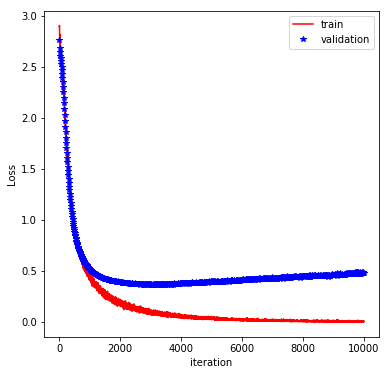

In [391]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

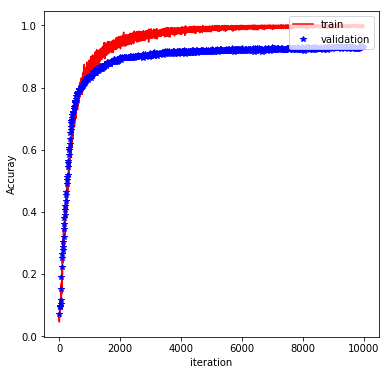

In [392]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate on test set

INFO:tensorflow:Restoring parameters from checkpoints-cnn/har.ckpt
Test accuracy: 0.716667
(array([ 1.  ,  0.95,  1.  ,  0.93,  0.98,  0.91,  1.  ,  0.4 ,  0.48,
        1.  ,  0.23,  1.  ,  0.64,  1.  ,  1.  ,  0.5 ]), array([ 1.  ,  1.  ,  0.93,  1.  ,  0.95,  0.98,  0.94,  0.88,  0.78,
        0.72,  0.09,  0.03,  0.94,  0.94,  1.  ,  1.  ]), array([ 1.  ,  0.98,  0.97,  0.97,  0.96,  0.94,  0.97,  0.55,  0.6 ,
        0.84,  0.13,  0.05,  0.76,  0.97,  1.  ,  0.67]), array([20, 21, 15, 14, 55, 41, 16, 32, 36, 36, 70, 74, 72, 34, 32, 32]))
Accuracy: 0.716666666667
F1 score: 0.716666666667
Recall: 0.716666666667
Precision: 0.716666666667

 clasification report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        20
          1       0.95      1.00      0.98        21
          2       1.00      0.93      0.97        15
          3       0.93      1.00      0.97        14
          4       0.98      0.95      0.96        55
         

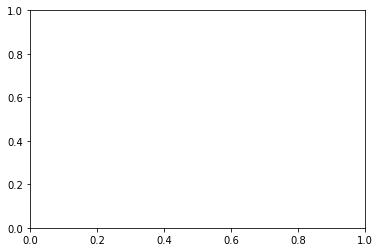

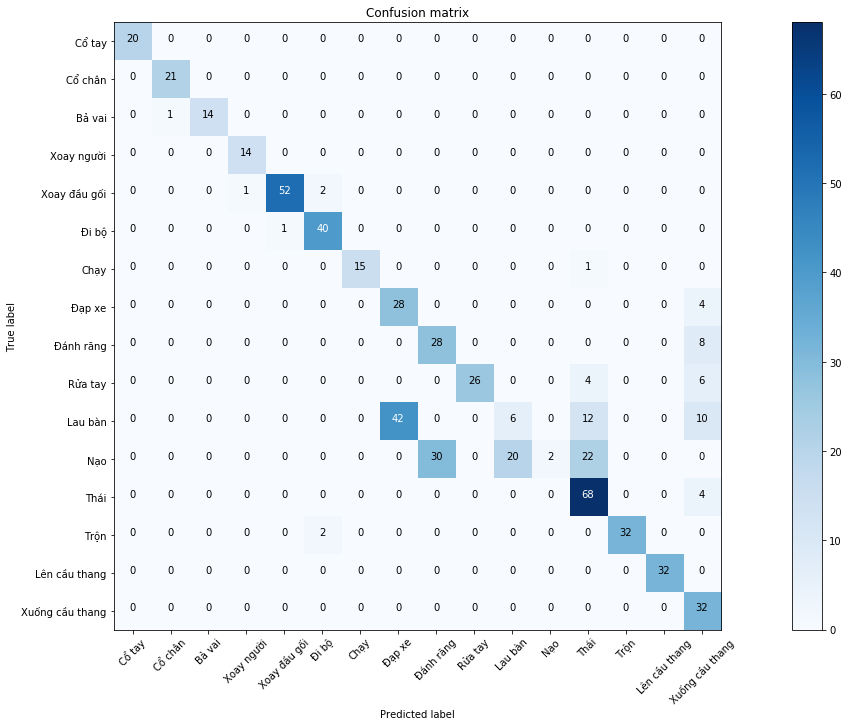

In [393]:
test_acc = []
with graph.as_default():
    prediction=tf.argmax(logits,1)
with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    y_pred = []
    y_true = []
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        batch_acc, batch_y_pred = sess.run([accuracy, prediction], feed_dict=feed)
        y_pred.extend(batch_y_pred)
        y_true.extend(np.where(r==1)[0][0] for r in y_t )
        
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))
#     print y_true
#     print y_pred
    sk_class_labels = [i for i in range(NUM_CLASS)]
    cnf_matrix = confusion_matrix(y_true, y_pred)
    print precision_recall_fscore_support(y_true, y_pred, average=None, labels=sk_class_labels)
    print 'Accuracy:', accuracy_score(y_true, y_pred)
    print 'F1 score:', f1_score(y_true, y_pred, average='micro')
    print 'Recall:', recall_score(y_true, y_pred, average='micro')
    print 'Precision:', precision_score(y_true, y_pred, average='micro')
    print '\n clasification report:\n', classification_report(y_true,y_pred)
    print '\n confussion matrix:\n',cnf_matrix
    fig, ax = plt.subplots() 
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 20
    fig_size[1] = 10
    plt.rcParams["figure.figsize"] = fig_size
    plt.figure()
    plot_confusion_matrix(cnf_matrix, class_label_vn, title='Confusion matrix')

    plt.show()